In [152]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import warnings
warnings.filterwarnings('ignore')

**Load Data**

In [153]:
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')
print(train_df.shape, test_df.shape)

(146811, 3) (60427, 2)


**EDA**

In [154]:
train_df.head()

review_id                                             review  rating
0          0  Ga disappointed neat products .. Meletot Hilsn...       1
1          1    Rdtanya replace broken glass, broken chargernya       1
2          2  Nyesel bngt dsni shopping antecedent photo mes...       1
3          3      Sent a light blue suit goods ga want a refund       1
4          4  Pendants came with dents and scratches on its ...       1

In [155]:
test_df.head()

review_id                                             review
0          1  Great danger, cool, motif and cantik2 jg model...
1          2                   One of the shades don't fit well
2          3                                   Very comfortable
3          4  Fast delivery. Product expiry is on Dec 2022. ...
4          5  it's sooooo cute! i like playing with the glit...

**Check for duplicate reviews**

In [156]:
dup_df = train_df[train_df['review'].duplicated()]
print(f'No. of duplicate reviews on train data: {dup_df.shape[0]}')

No. of duplicate reviews on train data: 31483


**Check if the duplicate reviews have the same rating**

In [157]:
dup_df['check'] = dup_df.apply(lambda x: str(x.review) + str(x.rating), axis = 1)
print(dup_df['check'].duplicated().sum(),'of duplicate reviews have the same rating')

28523 of duplicate reviews have the same rating


**Since most of the duplicate reviews have the same rating, we could choose to drop them**

In [158]:
train_df.drop_duplicates(subset = 'review', inplace = True)

**Length statistics**

***The length will be needed to identify the amount of dimensions used for the model***

In [159]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def count_len(text):
    return len(word_tokenize(text))

[nltk_data] Downloading package punkt to /home/nvt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [160]:
train_df['len'] = train_df['review'].apply(count_len)
test_df['len'] = test_df['review'].apply(count_len)

<Axes: >

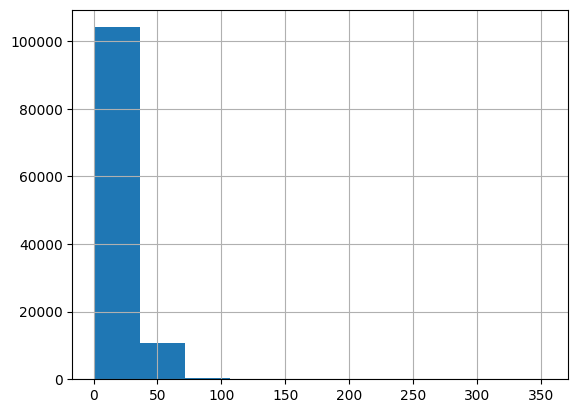

In [161]:
train_df['len'].hist()

<Axes: >

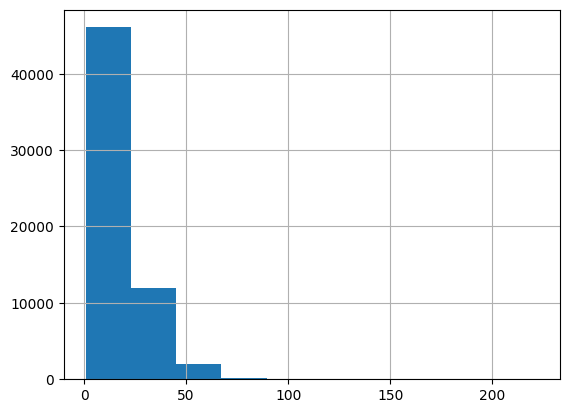

In [162]:
test_df['len'].hist()

**We could use MAX_LEN=125 as the number of dimensions for our model**

**Extend train data with publicly, freely available external data**

In [163]:
# kaggle.com/liuhh02/test-labelled
# old test leak labelled
test_labelled = pd.read_csv('datasets/test_labelled.csv')
test_labelled

review_id                                             review  rating
0              0                                      slow delivery       1
1              1               Dateng goods do not conform pesanan😔       1
2              2                             PSN k its 20 other DTG       1
3              3  I am expected that it have a frame and painted...       1
4              4                   The product quality is not good.       1
...          ...                                                ...     ...
62913      62913  Has shipped It was the model that fits the cut...       5
62914      62914       Awesome awesome speed of the ship's value CP       5
62915      62915  but already in lebihin one of its usual size w...       5
62916      62916                  The product quality is excellent.       5
62917      62917  Excellent product quality, original product, t...       5

[62918 rows x 3 columns]

In [164]:
dup_testlab = test_labelled[test_labelled['review'].duplicated()]
print(f'No. of duplicate reviews: {dup_testlab.shape[0]}')
dup_testlab['check'] = dup_testlab.apply(lambda x: str(x.review) + str(x.rating), axis = 1)
print(dup_testlab['check'].duplicated().sum(),'of duplicate reviews have the same rating')

No. of duplicate reviews: 13040
11667 of duplicate reviews have the same rating


In [165]:
test_labelled.drop_duplicates(subset = 'review', inplace = True)

In [166]:
dup_testlab = test_labelled[test_labelled['review'].duplicated()]
print(f'No. of duplicate reviews: {dup_testlab.shape[0]}')

No. of duplicate reviews: 0


In [167]:
# kaggle.com/shymammoth/shopee-reviews
# scraped shopee reviews
scraped_reviews = pd.read_csv('datasets/shopee_reviews.csv')
scraped_reviews

label                                               text
0           5  Looks ok. Not like so durable. Will hv to use ...
1           5  Tried, the current can be very powerful depend...
2           5  Item received after a week. Looks smaller than...
3           5  Thanks!!! Works as describe no complaints. Not...
4           5  Fast delivery considering it’s from overseas a...
...       ...                                                ...
1502570     5  Tried and it fit nicely will buy \nFast and go...
1502571     5  It's a fantastic product. Very reasonable pric...
1502572     5  Nice pair of shoes for a gd price. Note the cu...
1502573     1  Leather?   Rubbish....moulded plastic. What a ...
1502574     3  Your size 41 smaller than normal, more like si...

[1502575 rows x 2 columns]

*Change column names for merging*

In [168]:
scraped_reviews.rename(columns = {'text': 'review', 'label': 'rating'}, inplace = True)
scraped_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502575 entries, 0 to 1502574
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   rating  1502575 non-null  object
 1   review  1502574 non-null  object
dtypes: object(2)
memory usage: 22.9+ MB


In [169]:
scraped_reviews['rating'].value_counts()

rating
5        1137695
5         166237
4          88686
3          42911
1          24704
2          16724
4          13443
3           6172
1           3650
2           2352
label          1
Name: count, dtype: int64

In [170]:
scraped_reviews = scraped_reviews[scraped_reviews['rating'] != 'label']
scraped_reviews['rating'] = scraped_reviews['rating'].astype(int)
scraped_reviews['rating'].value_counts()

rating
5    1303932
4     102129
3      49083
1      28354
2      19076
Name: count, dtype: int64

In [171]:
dup_scraped = scraped_reviews[scraped_reviews['review'].duplicated()]
print(f'No. of duplicate reviews: {dup_scraped.shape[0]}')

No. of duplicate reviews: 0


In [172]:
train_df = pd.concat([train_df, test_labelled], ignore_index=True)
train_df = pd.concat([train_df, scraped_reviews], ignore_index=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

**Final check for duplicates**

In [173]:
dup_train = train_df[train_df['review'].duplicated()]
print(f'No. of duplicate reviews on train data: {dup_train.shape[0]}')
dup_train['check'] = dup_train.apply(lambda x: str(x.review) + str(x.rating), axis = 1)
print(dup_train['check'].duplicated().sum(),'of duplicate reviews have the same rating')

No. of duplicate reviews on train data: 33166
177 of duplicate reviews have the same rating


In [174]:
train_df

review_id                                             review  rating  \
0              NaN  Received in good condition. Fast delivery. Com...       5   
1              NaN  Good item and fast delivery!!! Seems good qual...       5   
2              NaN  Very nice casings! It fits well and the dark r...       5   
3              NaN                     Item came in great condition 👍       5   
4              NaN                           Good quality and design        5   
...            ...                                                ...     ...   
1667775        NaN  Ok not so bad can rotate but can’t change to s...       4   
1667776        NaN                            Material soft, not bad        5   
1667777        NaN                     Received but smell not strong        5   
1667778        NaN  Fast shipping despite current situation, comes...       4   
1667779        NaN  So nice packing, very fast deliver. Well done!...       5   

         len  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
...      ...  
1667775  NaN  
1667776  NaN  
1667777  NaN  
1667778  NaN  
1667779  NaN  

[1667780 rows x 4 columns]

# Data Cleaning

In [175]:
train_df['rating'].value_counts()

rating
5    1347428
4     147498
3      89644
1      48145
2      35065
Name: count, dtype: int64

**Trim train set by half to minimize training time**

In [176]:
train_df = train_df.drop(train_df[train_df['rating'] == 5].sample(frac = .9).index)
train_df = train_df.drop(train_df[train_df['rating'] == 4].sample(frac = .5).index)
print(train_df['rating'].value_counts())
print(train_df.shape)

rating
5    134743
3     89644
4     73749
1     48145
2     35065
Name: count, dtype: int64
(381346, 4)


**Join train and test for cleaning**

In [177]:
# adding column 'rating' to test dataset
test_df['rating'] = -1 # flag to separate train and test

# joining train and test datasets
reviews = pd.concat([train_df, test_df], ignore_index = True)
reviews

review_id                                             review  rating  \
0         38602.0  his goods are, hopefully fit, NNT LGI who trie...       3   
1         81497.0  The original product. Maximum fast delivery, m...       4   
2             NaN                  My daughter likes this very much.       4   
3             NaN  Box was crushed, dirty and the tag behind was ...       3   
4             NaN  I usually use M size.  \nBut this vest tank wa...       1   
...           ...                                                ...     ...   
441768    60423.0  Product has been succesfully ordered and shipp...      -1   
441769    60424.0  Opening time a little scared. Fear dalemnya de...      -1   
441770    60425.0   The product quality is excellent. The origina...      -1   
441771    60426.0             They 're holding up REALLY well also .      -1   
441772    60427.0  Rapid response and detail ...\nThanks gan, the...      -1   

         len  
0       13.0  
1       50.0  
2        NaN  
3        NaN  
4        NaN  
...      ...  
441768  27.0  
441769  18.0  
441770  34.0  
441771   8.0  
441772  19.0  

[441773 rows x 4 columns]

**Replace emoji with text**

In [178]:
import emoji  

have_emoji_train_idx = []

for idx, review in enumerate(reviews['review']):
    if isinstance(review, str) and any(char in emoji.EMOJI_DATA for char in review):
        have_emoji_train_idx.append(idx)

In [179]:
def emoji_cleaning(text):
    
    # change emoji to text
    text = emoji.demojize(text).replace(":", " ")
    
    # delete repeated emoji
    tokenizer = text.split()
    repeated_list = []
    
    for word in tokenizer:
        if word not in repeated_list:
            repeated_list.append(word)
    
    text = ' '.join(text for text in repeated_list)
    text = text.replace("_", " ").replace("-", " ")
    return text

In [180]:
reviews.loc[have_emoji_train_idx, 'review'] = reviews.loc[have_emoji_train_idx, 'review'].apply(emoji_cleaning)

In [181]:
def review_cleaning(text):
    
    text = text.lower()
    text = re.sub(r'\n', '', text)
    
#     text = text.replace("n't", ' not')
    
    # change emoticon to text
    text = re.sub(r':\(', 'dislike', text)
    text = re.sub(r': \(\(', 'dislike', text)
    text = re.sub(r':, \(', 'dislike', text)
    text = re.sub(r':\)', 'smile', text)
    text = re.sub(r';\)', 'smile', text)
    text = re.sub(r':\)\)\)', 'smile', text)
    text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
    text = re.sub(r'=\)\)\)\)', 'smile', text)
    
#     # delete punctuation
#     text = re.sub('[^a-z0-9 ]', ' ', text)
    
    tokenizer = text.split()
    
    return ' '.join([text for text in tokenizer])

In [182]:
reviews['review'] = reviews['review'].apply(review_cleaning)

**Remove repeated letters**

In [183]:
repeated_rows_train = []

for idx, review in enumerate(reviews['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_train.append(idx)

In [184]:
def delete_repeated_char(text):
    
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    
    return text

In [185]:
reviews.loc[repeated_rows_train, 'review'] = reviews.loc[repeated_rows_train, 'review'].apply(delete_repeated_char)

**Recover shortened words**

In [186]:
def recover_shortened_words(text):
    
    text = re.sub(r'\bapaa\b', 'apa', text)
    
    text = re.sub(r'\bbsk\b', 'besok', text)
    text = re.sub(r'\bbrngnya\b', 'barangnya', text)
    text = re.sub(r'\bbrp\b', 'berapa', text)
    text = re.sub(r'\bbgt\b', 'banget', text)
    text = re.sub(r'\bbngt\b', 'banget', text)
    text = re.sub(r'\bgini\b', 'begini', text)
    text = re.sub(r'\bbrg\b', 'barang', text)
    
    text = re.sub(r'\bdtg\b', 'datang', text)
    text = re.sub(r'\bd\b', 'di', text)
    text = re.sub(r'\bsdh\b', 'sudah', text)
    text = re.sub(r'\bdri\b', 'dari', text)
    text = re.sub(r'\bdsni\b', 'disini', text)
    
    text = re.sub(r'\bgk\b', 'gak', text)
    
    text = re.sub(r'\bhrs\b', 'harus', text)
    
    text = re.sub(r'\bjd\b', 'jadi', text)
    text = re.sub(r'\bjg\b', 'juga', text)
    text = re.sub(r'\bjgn\b', 'jangan', text)
    
    text = re.sub(r'\blg\b', 'lagi', text)
    text = re.sub(r'\blgi\b', 'lagi', text)
    text = re.sub(r'\blbh\b', 'lebih', text)
    text = re.sub(r'\blbih\b', 'lebih', text)
    
    text = re.sub(r'\bmksh\b', 'makasih', text)
    text = re.sub(r'\bmna\b', 'mana', text)
    
    text = re.sub(r'\borg\b', 'orang', text)
    
    text = re.sub(r'\bpjg\b', 'panjang', text)
    
    text = re.sub(r'\bka\b', 'kakak', text)
    text = re.sub(r'\bkk\b', 'kakak', text)
    text = re.sub(r'\bklo\b', 'kalau', text)
    text = re.sub(r'\bkmrn\b', 'kemarin', text)
    text = re.sub(r'\bkmrin\b', 'kemarin', text)
    text = re.sub(r'\bknp\b', 'kenapa', text)
    text = re.sub(r'\bkcil\b', 'kecil', text)
    
    text = re.sub(r'\bgmn\b', 'gimana', text)
    text = re.sub(r'\bgmna\b', 'gimana', text)
    
    text = re.sub(r'\btp\b', 'tapi', text)
    text = re.sub(r'\btq\b', 'thanks', text)
    text = re.sub(r'\btks\b', 'thanks', text)
    text = re.sub(r'\btlg\b', 'tolong', text)
    text = re.sub(r'\bgk\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    text = re.sub(r'\bgpp\b', 'tidak apa apa', text)
    text = re.sub(r'\bgapapa\b', 'tidak apa apa', text)
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\btgl\b', 'tanggal', text)
    text = re.sub(r'\btggl\b', 'tanggal', text)
    text = re.sub(r'\bgamau\b', 'tidak mau', text)
    
    text = re.sub(r'\bsy\b', 'saya', text)
    text = re.sub(r'\bsis\b', 'sister', text)
    text = re.sub(r'\bsdgkan\b', 'sedangkan', text)
    text = re.sub(r'\bmdh2n\b', 'semoga', text)
    text = re.sub(r'\bsmoga\b', 'semoga', text)
    text = re.sub(r'\bsmpai\b', 'sampai', text)
    text = re.sub(r'\bnympe\b', 'sampai', text)
    text = re.sub(r'\bdah\b', 'sudah', text)
    
    text = re.sub(r'\bberkali2\b', 'repeated', text)
    
    text = re.sub(r'\byg\b', 'yang', text)
    
    return text

In [187]:
reviews['review'] = reviews['review'].apply(recover_shortened_words)

**Lemmatization**

In [188]:
from nltk.stem import WordNetLemmatizer
from string import punctuation

lemma = WordNetLemmatizer()

In [189]:
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [190]:
def clean_review(review_col):
    review_corpus=[]
    
    for i in range(0, len(review_col)):
        review_text = str(review_col[i])
        review_text = re.sub('[^a-zA-Z]', ' ', review_text)
        review_text = [lemma.lemmatize(w) for w in word_tokenize(str(review_text).lower())]
        review_text = ' '.join(review_text)
        
        review_corpus.append(review_text)
        
    return review_corpus

In [191]:
reviews

review_id                                             review  rating  \
0         38602.0  his goods are, hopefully fit, nnt lagi who tri...       3   
1         81497.0  the original product. maximum fast delivery, m...       4   
2             NaN                  my daughter likes this very much.       4   
3             NaN  box was crushed, dirty and the tag behind was ...       3   
4             NaN  i usually use m size. but this vest tank was t...       1   
...           ...                                                ...     ...   
441768    60423.0  product has been succesfully ordered and shipp...      -1   
441769    60424.0  opening time a little scared. fear dalemnya de...      -1   
441770    60425.0  the product quality is excellent. the original...      -1   
441771    60426.0             they 're holding up really well also .      -1   
441772    60427.0  rapid response and detail ...thanks gan, the g...      -1   

         len  
0       13.0  
1       50.0  
2        NaN  
3        NaN  
4        NaN  
...      ...  
441768  27.0  
441769  18.0  
441770  34.0  
441771   8.0  
441772  19.0  

[441773 rows x 4 columns]

In [192]:
# cleaning round 2, lemmatization
nltk.download('wordnet')

reviews['review'] = clean_review(reviews['review'].values)
reviews

[nltk_data] Downloading package wordnet to /home/nvt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


review_id                                             review  rating  \
0         38602.0  his good are hopefully fit nnt lagi who tried ...       3   
1         81497.0  the original product maximum fast delivery mes...       4   
2             NaN                    my daughter like this very much       4   
3             NaN  box wa crushed dirty and the tag behind wa kin...       3   
4             NaN  i usually use m size but this vest tank wa too...       1   
...           ...                                                ...     ...   
441768    60423.0  product ha been succesfully ordered and shippe...      -1   
441769    60424.0  opening time a little scared fear dalemnya des...      -1   
441770    60425.0  the product quality is excellent the original ...      -1   
441771    60426.0                they re holding up really well also      -1   
441772    60427.0  rapid response and detail thanks gan the good ...      -1   

         len  
0       13.0  
1       50.0  
2        NaN  
3        NaN  
4        NaN  
...      ...  
441768  27.0  
441769  18.0  
441770  34.0  
441771   8.0  
441772  19.0  

[441773 rows x 4 columns]

**Separating train and test sets**

In [193]:
train_df = reviews[reviews.rating != -1]
train_df.drop(['review_id'], axis = 1, inplace = True)
train_df.head()

review  rating   len
0  his good are hopefully fit nnt lagi who tried ...       3  13.0
1  the original product maximum fast delivery mes...       4  50.0
2                    my daughter like this very much       4   NaN
3  box wa crushed dirty and the tag behind wa kin...       3   NaN
4  i usually use m size but this vest tank wa too...       1   NaN

In [194]:
test_df = reviews[reviews.rating == -1]
test_df.drop(['rating'], axis = 1, inplace = True)
test_df['review_id'] = test_df['review_id'].astype(int)
test_df.head()

review_id                                             review   len
381346          1  great danger cool motif and cantik juga model ...  27.0
381347          2                    one of the shade don t fit well   8.0
381348          3                                   very comfortable   2.0
381349          4  fast delivery product expiry is on dec product...  20.0
381350          5  it s sooooo cute i like playing with the glitt...  41.0

**Save to file: clean extended train and test data**

In [195]:
train_df[['review', 'rating']].to_csv('datasets/clean_extended_train.csv', index = False)
test_df[['review_id', 'review']].to_csv('datasets/clean_test_up.csv', index = False)

In [196]:
train_df

review  rating   len
0       his good are hopefully fit nnt lagi who tried ...       3  13.0
1       the original product maximum fast delivery mes...       4  50.0
2                         my daughter like this very much       4   NaN
3       box wa crushed dirty and the tag behind wa kin...       3   NaN
4       i usually use m size but this vest tank wa too...       1   NaN
...                                                   ...     ...   ...
381341  there is a small crack on the container but ov...       4   NaN
381342  good material and nice design would definitely...       4   NaN
381343  not really my preference really oily on skin a...       1   NaN
381344  according to the image material thickness quic...       3  10.0
381345  ok not so bad can rotate but can t change to s...       4   NaN

[381346 rows x 3 columns]

In [197]:
test_df

review_id                                             review   len
381346          1  great danger cool motif and cantik juga model ...  27.0
381347          2                    one of the shade don t fit well   8.0
381348          3                                   very comfortable   2.0
381349          4  fast delivery product expiry is on dec product...  20.0
381350          5  it s sooooo cute i like playing with the glitt...  41.0
...           ...                                                ...   ...
441768      60423  product ha been succesfully ordered and shippe...  27.0
441769      60424  opening time a little scared fear dalemnya des...  18.0
441770      60425  the product quality is excellent the original ...  34.0
441771      60426                they re holding up really well also   8.0
441772      60427  rapid response and detail thanks gan the good ...  19.0

[60427 rows x 3 columns]

# Preprocessing

## Tokenization

**Change range of rating from (1 to 5) to (0 to 4)**

In [198]:
# since keras takes 0 as the reference, our category should start from 0 not 1
rating_mapper_encode = {1: 0,
                        2: 1,
                        3: 2,
                        4: 3,
                        5: 4}

# convert back to original rating after prediction later
rating_mapper_decode = {0: 1,
                        1: 2,
                        2: 3,
                        3: 4,
                        4: 5}

train_df['rating'] = train_df['rating'].map(rating_mapper_encode)

In [199]:
from keras.utils import to_categorical

# convert to one-hot-encoding-labels
train_labels = to_categorical(train_df['rating'], num_classes=5)

In [200]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df['review'],
                                                  train_labels,
                                                  stratify=train_labels,
                                                  test_size=0.1,
                                                  random_state=1111)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((343211,), (38135,), (343211, 5), (38135, 5))

In [201]:
X_test = test_df['review'].values.tolist()

**Transform reviews into tokens**

In [202]:
# import package
from gensim.utils import tokenize

In [203]:
def tokenize_data(data_set):
    tokenized_set = []
    for doc in data_set:
        tokens = list(tokenize(doc, lowercase=True, deacc=True))
        tokenized_set.append(tokens)
    return tokenized_set

In [204]:
X_train = tokenize_data(X_train.values.tolist())
X_val = tokenize_data(X_val.values.tolist())
X_test = tokenize_data(test_df['review'].values.tolist())

In [205]:
len(X_train)

343211

In [206]:
len(X_val)

38135

In [207]:
len(X_test)

60427

In [208]:
train_df['review']

0         his good are hopefully fit nnt lagi who tried ...
1         the original product maximum fast delivery mes...
2                           my daughter like this very much
3         box wa crushed dirty and the tag behind wa kin...
4         i usually use m size but this vest tank wa too...
                                ...                        
381341    there is a small crack on the container but ov...
381342    good material and nice design would definitely...
381343    not really my preference really oily on skin a...
381344    according to the image material thickness quic...
381345    ok not so bad can rotate but can t change to s...
Name: review, Length: 381346, dtype: object

## Vectorization

In [209]:
from gensim.models import Word2Vec
import numpy as np

# Vectorize the text
def vectorize_text(text_list, embedding_size=125, min_count=1):

    # Train Word2Vec model
    model = Word2Vec(text_list, vector_size=embedding_size, min_count=min_count)

    # Vectorize the text
    vectorized_text_list = []
    for text in text_list:
        vectors = []
        for word in text:
            if word in model.wv:
                vectors.append(model.wv[word])
        if vectors:
            vectorized_text_list.append(np.mean(vectors, axis=0))
        else:
            # If none of the words in the text are in the vocabulary, assign zero vector
            vectorized_text_list.append(np.zeros(embedding_size))

    return vectorized_text_list

In [210]:
X_train_vec = vectorize_text(X_train, embedding_size=125)

In [211]:
# Vectorize the text
X_val_vec = vectorize_text(X_val, embedding_size=125)

In [212]:
X_test_vec = vectorize_text(X_test, embedding_size=125)

In [213]:
len(X_train_vec)

343211

In [214]:
len(X_val_vec)

38135

In [215]:
len(X_test_vec)

60427

In [216]:
# import math
# from collections import Counter
#
# def calculate_term_frequency(review_txt):
#     review_tf = Counter(review_txt)
#     total_tokens = len(review_txt)
#     return {token: count / total_tokens for token, count in review_tf.items()}
#
# def calculate_inverse_document_frequency(review_list):
#     idf_scores = {}
#     total_reviews = len(reviews)
#     for review_text in review_list:
#         unique_tokens = set(review_text)
#         for token in unique_tokens:
#             if token not in idf_scores:
#                 num_reviews_with_token = sum(1 for r in review_list if token in r)
#                 idf_scores[token] = math.log(total_reviews / num_reviews_with_token)
#     return idf_scores
#
# def calculate_tfidf(tf_scores, idf_scores):
#     review_tfidf = {token: tf * idf_scores[token] for token, tf in tf_scores.items()}
#     return review_tfidf
#
# def vectorize_tfidf(unique_tokens, tfidf_scores):
#     token_index = {token: i for i, token in enumerate(unique_tokens)}
#     tfidf_vectors = []
#     for review_tfidf in tfidf_scores:
#         review_vector = [0.0] * len(unique_tokens)
#         for token, tfidf_score in review_tfidf.items():
#             token_idx = token_index[token]
#             review_vector[token_idx] = tfidf_score
#         tfidf_vectors.append(review_vector)
#     return tfidf_vectors
#
# def vectorize(review_list):
#     tf_scores = [calculate_term_frequency(review_text) for review_text in review_list]
#     # print("TF Scores:")
#     # for i, tf_score in enumerate(tf_scores):
#     #     print(f"Review {i+1}: {tf_score}")
#
#     idf_scores = calculate_inverse_document_frequency(review_list)
#     # print("\nIDF Scores:")
#     # for token, idf_score in idf_scores.items():
#     #     print(f"{token}: {idf_score}")
#
#     tfidf_scores = [calculate_tfidf(tf_score, idf_scores) for tf_score in zip(tf_scores)]
#     # print("\nTF-IDF Scores:")
#     # for i, tfidf_score in enumerate(tfidf_scores):
#     #     print(f"Review {i+1}: {tfidf_score}")
#
#     unique_tokens = set(token for review_text in review_list for token in review_text)
#     tfidf_vectors = vectorize_tfidf(unique_tokens, tfidf_scores)
#     # print("\nTF-IDF Vectors:")
#     # for i, vector in enumerate(tfidf_vectors):
#     #     print(f"Review {i+1}: {vector}")
#     return tfidf_vectors


In [217]:
# import pandas as pd
# from gensim import corpora, models
#
# def tf_idf(review_list):
#     # Create a list of tokenized texts
#     tokenized_reviews = [review_text.split() for review_text in review_list]
#
#     # Create a dictionary from the tokenized texts
#     dictionary = corpora.Dictionary(tokenized_reviews)
#
#     # Convert the tokenized texts into bag-of-words representation
#     corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_reviews]
#
#     # Train the TF-IDF model
#     tfidf_model = models.TfidfModel(corpus)
#     tfidf_vectorized = [tfidf_model[doc] for doc in corpus]
#
#     # Extract only the TF-IDF scores
#     tfidf_scores = [[score for _, score in doc] for doc in tfidf_vectorized]
#
#     # Pad the TF-IDF scores with zeros if necessary
#     padded_tfidf_scores = [row + [0] * (125 - len(row)) for row in tfidf_scores]
#
#     # Convert the padded TF-IDF scores to a DataFrame
#     tfidf_scores_df = pd.DataFrame(padded_tfidf_scores).fillna(0)
#
#     return tfidf_scores_df

In [218]:
# X_train_vec = tf_idf(X_train)

In [219]:
# X_val_vec = tf_idf(X_val)

In [220]:
# X_test_vec = tf_idf(X_test)

In [221]:
X_train_vec

[array([-0.6024596 ,  1.2786272 , -0.5060967 , -0.20476817,  0.14697094,
        -0.90780455, -0.04176165, -0.9115777 , -1.3790222 ,  0.46622825,
        -0.6485937 , -0.9081206 , -0.86454916, -0.3866892 ,  0.69021773,
        -0.8713506 , -0.23532285, -0.5104162 ,  1.0262392 ,  0.36378393,
        -0.2980149 ,  0.4713491 , -0.48083326, -0.01365046, -0.3289907 ,
         1.1096504 ,  0.10140469,  0.4912335 ,  0.09388594,  0.4398997 ,
        -0.09261479, -0.34366062,  0.01615547, -0.7063412 ,  0.07191265,
         0.03210618,  0.6491148 ,  0.74346995, -0.1600579 ,  1.5294334 ,
         0.30577448, -0.5925896 , -0.00335907,  0.40183315, -0.44251576,
        -0.25761417, -0.69225454,  0.09867915,  0.03555155,  0.05271997,
         1.2644376 , -0.0359957 ,  0.63422245, -0.7219004 ,  0.60315186,
         0.06887306,  0.1911669 ,  0.58587164,  0.37576923, -0.07700697,
         0.3610482 , -0.00439568,  0.26520348, -0.4766558 ,  0.72018814,
         0.15575679, -0.04534161,  0.05823569,  0.4

In [222]:
X_val_vec

[array([-1.88361034e-01, -4.45347577e-01,  7.19031632e-01, -4.71172303e-01,
         6.56574545e-03, -4.11977291e-01,  4.41816002e-01,  1.55105531e+00,
        -1.12049924e-02,  4.10818994e-01,  3.44692647e-01,  1.28415942e-01,
         2.76172310e-01, -1.54971227e-01, -3.29982460e-01,  2.63110232e-02,
        -1.65558422e+00, -4.38094139e-04, -1.24829635e-01,  4.76298392e-01,
         1.41324447e-02, -3.70470211e-02,  5.25815308e-01,  3.23635787e-01,
         5.25042176e-01, -1.31808341e+00,  6.01551414e-01,  1.34582669e-01,
        -6.41476810e-02, -9.40106660e-02,  4.41939116e-01,  3.58201176e-01,
        -4.56562340e-01, -6.28086865e-01,  2.23471165e-01, -8.71999204e-01,
         6.44045353e-01, -3.08533274e-02, -3.74884874e-01, -2.22398743e-01,
         2.64099509e-01,  6.80095017e-01, -6.19373202e-01,  1.14519075e-01,
        -1.32666588e-01, -1.97769180e-01, -1.95595890e-01,  3.58574182e-01,
         1.37538123e+00, -3.44505370e-01, -1.29791517e-02,  2.80411869e-01,
         5.7

In [223]:
X_test_vec

[array([ 0.08323675, -0.21938217,  0.5273586 ,  0.21967359, -0.28204617,
         0.4860557 , -0.03451255,  0.30404463,  0.48024464,  0.02641249,
         0.13207397,  0.08940247,  0.02067378, -0.3519643 ,  0.02800886,
         0.295094  , -0.7265937 ,  0.1161613 , -0.09504251, -0.0214501 ,
         0.3890329 ,  0.09092499,  0.04065185, -0.01504646,  0.28829437,
         0.07053702,  0.01186134, -0.8392982 ,  0.04750535, -0.68260854,
         0.28435454,  0.852107  ,  0.01090974, -0.27155086,  0.34549662,
         0.14249766,  0.36346242, -0.03579346, -0.30232057, -0.7513792 ,
         0.16972414,  0.94144475, -0.5527513 , -0.17536598, -0.4126729 ,
        -0.4928148 ,  0.08672099, -0.4471906 , -0.03412692, -0.55857956,
        -0.55210537,  0.04398205, -0.19437   , -1.0585945 ,  0.8263155 ,
        -0.92137635,  0.2681277 ,  0.23671493, -0.05200298, -0.65032643,
         0.23598199, -0.35167295,  0.12864831, -0.35653254, -0.52589804,
         0.529692  ,  0.04524076, -0.07381762, -0.1

# ANN Model

In [224]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # return output
        pass

    def backward(self, output_gradient, learning_rate):
        # update params and return input gradient
        pass

In [225]:
class Dense(Layer):
    # Y = W * X + B, with the sizes are jx1, jxi, ix1, jx1 respectively
    def __init__(self, input_size, output_size):
        super().__init__()
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return np.dot(self.weights.T, output_gradient)

In [226]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        super().__init__()
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [227]:
class ReLU(Activation):
    def __init__(self):
        super().__init__(self.relu, self.relu_prime)

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_prime(x):
        return np.where(x > 0, 1, 0)

In [228]:
class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output

    def backward(self, output_gradient, learning_rate):
        # This version is faster than the one presented in the video
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

In [229]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)


In [230]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

In [231]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

In [232]:
len(y_train)

343211

In [233]:
# X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
# Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))
#
# network = [
#     Dense(2, 3),
#     ReLU(),
#     Dense(3, 1),
#     Sigmoid()
# ]
#
# train(network, mse, mse_prime, X, Y, epochs=10000, learning_rate=0.1)

In [241]:
import random
import numpy as np

random_indices = random.sample(range(len(X_train_vec)), 3000)
X = np.reshape(np.array(X_train_vec)[random_indices], (3000, 125, 1))
Y = np.reshape(np.array(y_train)[random_indices], (3000, 5, 1))

network = [
    Dense(125, 200),
    ReLU(),
    Dense(200, 5),
    Softmax()
]

train(network, mse, mse_prime, X, Y, epochs=200, learning_rate=0.01)

1/200, error=0.35202351430469186
2/200, error=0.3471397999865997
3/200, error=0.3018180597108747
4/200, error=0.27035150138090785
5/200, error=0.2569083517700392
6/200, error=0.25272228622882653
7/200, error=0.25088377060935646
8/200, error=0.24960479668377036
9/200, error=0.2503791569083186
10/200, error=0.2489639234844781
11/200, error=0.24818823723899403
12/200, error=0.2473571947015041
13/200, error=0.2472252476856559
14/200, error=0.24657623283943117
15/200, error=0.24609226373316687
16/200, error=0.24530572005007828
17/200, error=0.24494867509136165
18/200, error=0.2444120126799384
19/200, error=0.24439609927617403
20/200, error=0.24435623714016336
21/200, error=0.24384533367356973
22/200, error=0.2443102460664565
23/200, error=0.24400384623090068
24/200, error=0.24384007907432684
25/200, error=0.2434280856153851
26/200, error=0.24288658285867704
27/200, error=0.2426369418562577
28/200, error=0.24263148423624722
29/200, error=0.2431803453998198
30/200, error=0.24339059558794204
3

In [ ]:
y_train[:3000]

In [242]:
X_validate = np.reshape(X_val_vec, (len(X_val_vec), 125, 1))

y_pred = []
for x in X_validate:
    y_pred.append(predict(network, x))

In [243]:
y_pred_indexes = [np.argmax(vector) for vector in y_pred]

In [244]:
len(y_pred_indexes)

38135

In [245]:
y_val_indexes = [np.argmax(vector) for vector in y_val]

In [246]:
len(y_val_indexes)

38135

In [247]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_val_indexes, y_pred_indexes)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_val_indexes, y_pred_indexes, average='macro')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_val_indexes, y_pred_indexes, average='macro')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_val_indexes, y_pred_indexes, average='macro')
print("F1-score:", f1)


Accuracy: 0.23592500327782875
Precision: 0.2677497914176638
Recall: 0.23933606602079632
F1-score: 0.22278181830648053


In [248]:
# # Calculate precision, recall, and F1 score for each class
precision = precision_score(y_val_indexes, y_pred_indexes, average=None)
recall = recall_score(y_val_indexes, y_pred_indexes, average=None)
f1 = f1_score(y_val_indexes, y_pred_indexes, average=None)

# Print the metrics for each class
for i in range(len(precision)):
    print(f"Class {i}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print()

Class 0:
Precision: 0.1731244847485573
Recall: 0.21806853582554517
F1 Score: 0.19301470588235295

Class 1:
Precision: 0.1199831897457449
Recall: 0.3256344453949244
F1 Score: 0.17535508637236086

Class 2:
Precision: 0.20282518167714542
Recall: 0.27710843373493976
F1 Score: 0.23421809438498892

Class 3:
Precision: 0.17301770592763666
Recall: 0.12189830508474576
F1 Score: 0.14302760321374594

Class 4:
Precision: 0.6697983949892347
Recall: 0.25397061006382665
F1 Score: 0.36829360167895386



In [249]:
import pickle

# Assuming you have a trained model called 'network'
# Save the model to a file
filename = 'model1.pkl'
with open(filename, 'wb') as file:
    pickle.dump(network, file)

In [ ]:
import pickle

with open('model.pkl', 'rb') as file:
    network = pickle.load(file)